In [174]:
%load_ext autoreload
import glob
from sklearn.model_selection import train_test_split
import nibabel

import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.core.debugger import set_trace
import os

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from models.v2v import V2VModel

import yaml
from easydict import EasyDict as edict

from utils import check_patch, pad_arrays, normalize, load, create_dicts, video

from multiprocessing import cpu_count
N_CPU = cpu_count()

from skimage.feature import hog
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import data, exposure
import scipy.ndimage as ndi

from celluloid import Camera
from IPython.core.display import display, HTML

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
plt.rcParams['font.size'] = 20

# Loading

In [77]:
labels_components = np.load('labels_info.npy', allow_pickle=True).item()
single_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) == 2}

USE_GEOM_FEATURES = True
GEOM_FEATURES = ['thickness', 'sulc', 'curv']

root_label = '../fcd_data/normalized_label'
root_data = '../fcd_data/normalized_data/'
root_geom_features = '../fcd_data/preprocessed_data_anadezhda/'

paths_dict = create_dicts(root_label,
                         root_data,
                         root_geom_features, 
                         single_component_keys,
                         USE_GEOM_FEATURES, 
                         GEOM_FEATURES)

# Symmetry

In [89]:
def get_sym_patches(brain_tensor, 
                   label_tensor, 
                   fcd_center, 
                   pad):
    '''
    symm along x-axis
    '''
    X_max = brain_tensor.shape[0]
    x1,y,z = fcd_center
    
    dx = x1 - (X_max//2)
    x2 = (X_max//2) - dx  
    
    patch_fcd = brain_tensor[x1-pad:x1+pad,y-pad:y+pad,z-pad:z+pad]    
    fcd_label = label_tensor[x1-pad:x1+pad,y-pad:y+pad,z-pad:z+pad]   
    
    patch_nonfcd = brain_tensor[x2-pad:x2+pad,y-pad:y+pad,z-pad:z+pad][::-1,:] # symm reflection along x
    nonfcd_label = label_tensor[x2-pad:x2+pad,y-pad:y+pad,z-pad:z+pad][::-1,:] # symm reflection along x
    
    return patch_fcd, patch_nonfcd, fcd_label, nonfcd_label

In [90]:
k = '1' # subj label

path_dict = paths_dict[k] # paths for the given subj 
fcd_center = labels_components[k]['center'] # mass-center of the FCD area

pad=max(labels_components[k]['d_s']) # max size

brain_tensor, mask_tensor, label_tensor = load(path_dict)
brain_tensor = normalized(brain_tensor)

patch_fcd, patch_nonfcd, fcd_label, nonfcd_label = get_sym_patches(brain_tensor, 
                                                                   label_tensor, 
                                                                   fcd_center, 
                                                                   pad)


# Compare FCD vs non-FCD

In [129]:
plt.ioff()

fig, ax = plt.subplots(1,2)
X_max, Y_max, Z_max = patch_fcd.shape
camera = Camera(fig)
n_slides= Y_max - 1

for y_slice_pos in np.linspace(0,Y_max-1,n_slides,dtype=int):

    patch_fcd_slice = patch_fcd[:,y_slice_pos,:]
    ax[0].imshow(patch_fcd_slice, 'gray')
    fcd_label_slice = fcd_label[:,y_slice_pos,:]
    ax[0].imshow(fcd_label_slice, 'jet', interpolation='none', alpha=0.7)
    
    patch_nonfcd_slice = patch_nonfcd[:,y_slice_pos,:]
    ax[1].imshow(patch_nonfcd_slice, 'gray')
    nonfcd_label_slice = nonfcd_label[:,y_slice_pos,:]
    ax[1].imshow(nonfcd_label_slice, 'jet', interpolation='none', alpha=0.7)

    ax[0].set_title('FCD')
    ax[1].set_title('non-FCD')

    camera.snap()

animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

/media/tom/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [95]:
patch_diff = np.abs(patch_fcd - patch_nonfcd)

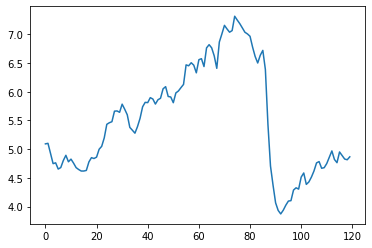

In [120]:
plt.figure()
plt.plot(np.linalg.norm(patch_diff, axis=(0,2)))
plt.show()

In [121]:
# plt.ioff()
# camera = video(patch_diff)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [171]:
def compute_2dhog(patch_fcd_slice):
    
    '''
    patch_fcd_slice - 2d grayscale image [H,W]
    '''
    
    fd = hog(patch_fcd_slice, 
            orientations=9, 
            pixels_per_cell=(4, 4),
            cells_per_block=(1, 1), 
            visualize=False, 
            feature_vector=False,
            multichannel=False)
    
    return fd

In [135]:
n_slides = 100
hogs_x = []
for y_slice_pos in tqdm(np.linspace(0,Y_max-1,n_slides,dtype=int)):

    patch_fcd_slice = patch_fcd[:,y_slice_pos,:]
    
    fd = compute_2dhog(patch_fcd_slice)
    
    hogs_x.append(fd.squeeze())
    
hogs_x = np.stack(hogs_x)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.97it/s]


In [155]:
hogs_x.shape

(100, 30, 30, 9)

In [166]:
hog_x_diff = np.diff(hogs_x, axis=0).sum(-1).mean(-1).mean(-1)

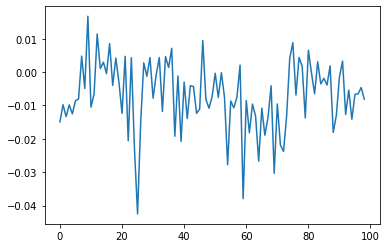

In [170]:
plt.ion()
plt.figure()
plt.plot(hog_x_diff)
plt.show()

# 2D HOG Entropy

In [ ]:
def entropy(x):
    if np.sum(x) == 0:
        return 0
    else:
        x_ = x/np.sum(x)
        return -np.sum(x_*np.log(x_ + 1e-5))

In [ ]:
plt.figure()
plt.imshow(np.apply_along_axis(entropy, 1, fd.reshape(-1,9)).reshape(30,30))
plt.colorbar()
plt.show()

# Entropy

In [228]:
def entropy(x):
    p,_ = np.histogram(x)
    p = p / p.sum()
    return -np.sum(p*np.log(p))

In [258]:
def renyi_entropy(x,alpha):
    p,_ = np.histogram(x,bins=100)
    p = p / p.sum()
    
    return np.log2(np.power(p,alpha).sum())*(1./(1-alpha))

In [259]:
x = np.random.uniform(size=1000)
entropy(x)

2.298450301932467

In [260]:
renyi_entropies = []
for alpha in np.linspace(0,100,100):
    renyi_entropies.append(renyi_entropy(x,alpha))

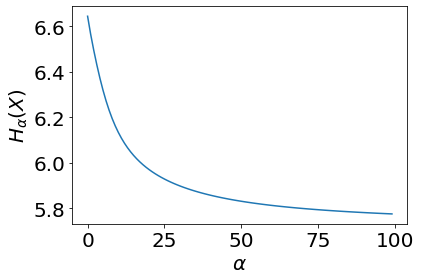

In [268]:
plt.plot(renyi_entropies)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$H_\alpha(X)$')

plt.show()

In [237]:
x = 3 + np.random.randn(1000) 
entropy(x)

1.9987852932394181